In [1]:
import skimage
import numpy as np
from skimage import io, transform
import os
import shutil
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import urllib.request
import urllib.error
import tarfile

%matplotlib inline

# Setting Directory Paths

Here we only extracting already labeled images. If you want to create your own dataset then you have to manually annotate them one by one.

In [2]:
root = os.getcwd()
imagePath = os.path.join(root, 'images')
trainPath = os.path.join(imagePath, 'train')
testPath = os.path.join(imagePath, 'test')

# Create Dataset for Training and Testing

In [3]:
tar = tarfile.open("images.tar.gz", "r:gz")
tar.extractall()
tar.close()

# Converting XML to CSV

In our dataset we have xml file which contains IMAGENAME.jpg and IMAGENAME.xml

In [ ]:
# Modified From:
# https://github.comr/datitran/raccoon_dataset/blob/master/xml_to_csv.py

os.chdir(root)

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    
    for i in [trainPath, testPath]:
        image_path = i
        folder = os.path.basename(os.path.normpath(i))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('data/'+folder+'.csv', index=None)
        print('Successfully converted xml to csv.')
    
main()

# Generate TF record

For training new data to pretrained model [tfrecord](http://goo.gl/oEyYyR) files used to optimise your data feed. We using generate a tfrecord using code adapted from this raccoon detector.

In [5]:
%%bash 

python3 generate_tfrecord.py
mv test.record data
mv train.record data

Successfully created the train TFRecords
Successfully created the test TFRecords


# Download Model

TensorFlow provide a collection of detection models pre-trained on the COCO dataset, the Kitti dataset, and the Open Images dataset. Some models have better performance but with less speed, And some models are faster but with less performance. In this model will use [ssd_inception_v2_coco](http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz). 

In [6]:
%%bash

wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
tar -xvzf ssd_inception_v2_coco_2017_11_17.tar.gz
rm -rf ssd_inception_v2_coco_2017_11_17/saved_model/

# Train Pre-trained Model

To train the model copy and paste the following code into a new terminal from the repository root directory. 


```
python3 object_detection/train.py \
--logtostderr \
--train_dir=data/ \
--pipeline_config_path=data/ssd_inception_v2_coco.config
```

# Copy Object Detection Utilities to Our Root Directory

In [7]:
%%bash

cp -R object_detection/utils/. utils

# Export Inference Graph

In [8]:
%%bash 
cd data
ls model*.index

model.ckpt-0.index
model.ckpt-253.index
model.ckpt-500.index


Now add the cpkt number to our trained_checkpoint argument.

In [11]:
%%bash 
rm -rf object_detection_graph
python3 object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path data/ssd_inception_v2_coco.config \
    --trained_checkpoint_prefix data/model.ckpt-500 \
    --output_directory object_detection_graph

Converted 410 variables to const ops.


Instructions for updating:
Please switch to tf.train.get_or_create_global_step
2018-04-09 20:39:08.772509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-04-09 20:39:08.773125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: GeForce 920M major: 3 minor: 5 memoryClockRate(GHz): 0.954
pciBusID: 0000:08:00.0
totalMemory: 1.96GiB freeMemory: 1.81GiB
2018-04-09 20:39:08.773175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: GeForce 920M, pci bus id: 0000:08:00.0, compute capability: 3.5)
2018-04-09 20:39:16.517594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: GeForce 920M, pci bus id: 0000:08:00.0, compute capability: 3.5)
2018-04-09 20:39:17.986420

# Test trained Model

In [5]:
# Modified From API
# https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
import matplotlib
from utils import label_map_util
from utils import visualization_utils as vis_util


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'object_detection_graph/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/label_map.pbtxt'

NUM_CLASSES = 3

validationPath = testPath = os.path.join(imagePath, 'validation')
output_dir = os.path.join(imagePath, 'output')
IMAGE_SIZE = (12, 12)

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

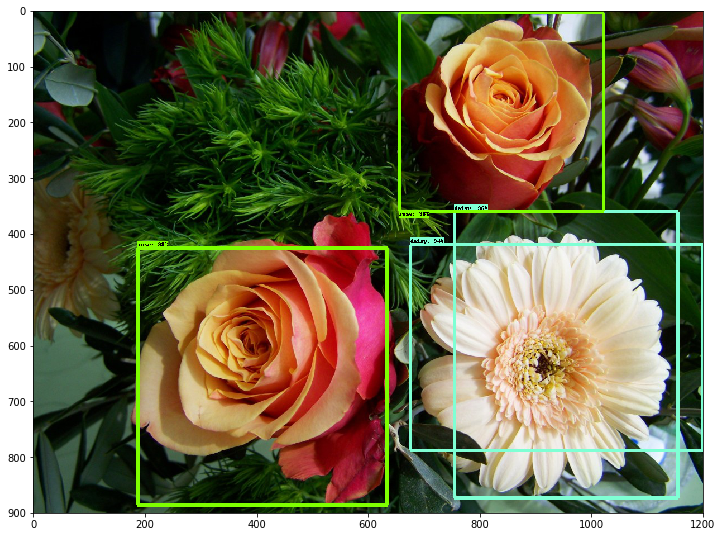

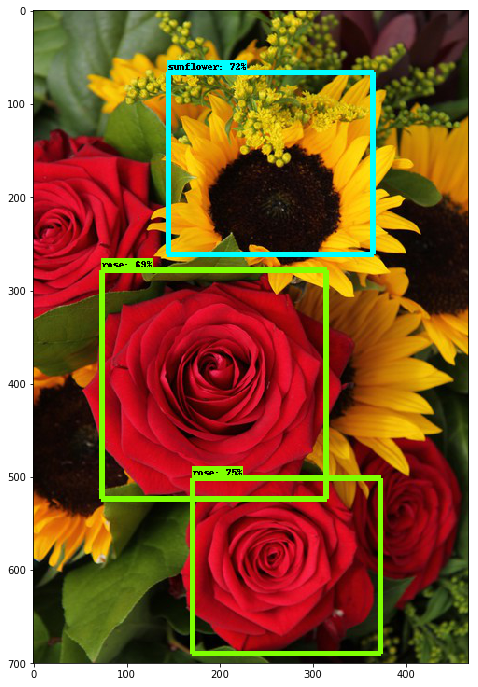

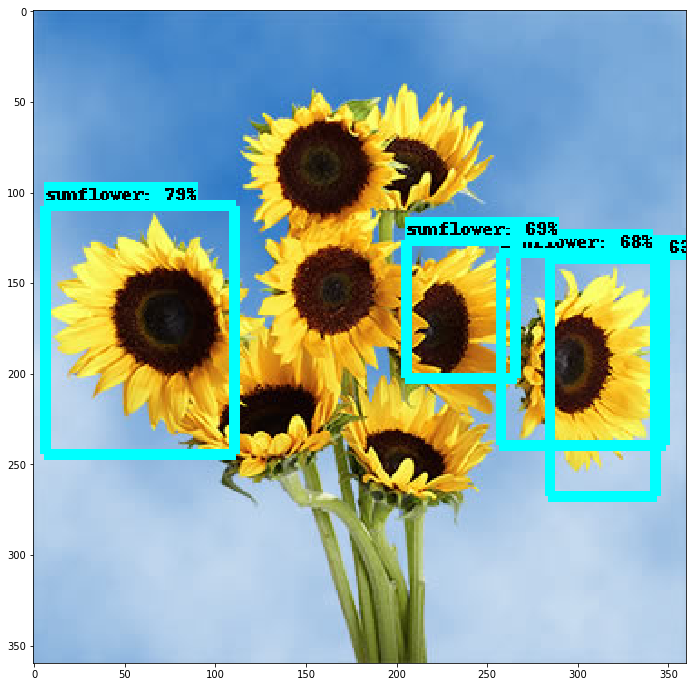

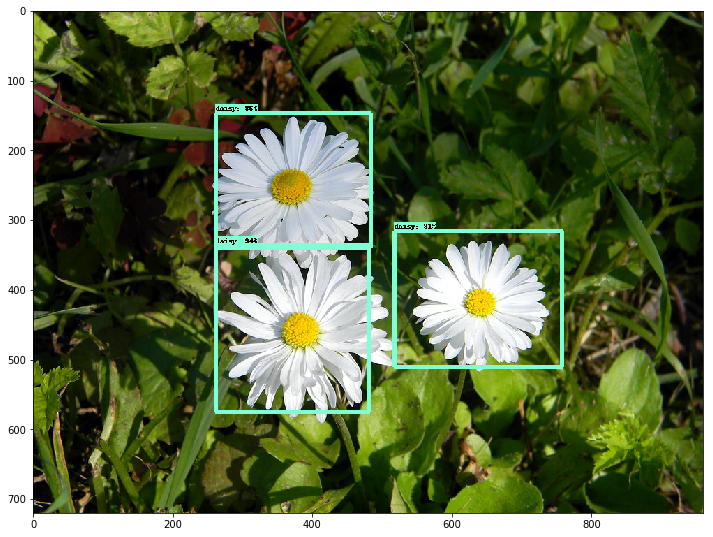

In [6]:
# Modified From API
# https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in os.listdir(validationPath):
      if image_path.endswith(".jpg"):
          image = Image.open(os.path.join(validationPath, image_path))
          # the array based representation of the image will be used later in order to prepare the
          # result image with boxes and labels on it.
          image_np = load_image_into_numpy_array(image)
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          image_np_expanded = np.expand_dims(image_np, axis=0)
          # Actual detection.
          (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
          # Visualization of the results of a detection.
          vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=6)
          plt.figure(figsize=IMAGE_SIZE)
          plt.imshow(image_np)
          plt.imsave(os.path.join(output_dir, image_path+'.png'), image_np) 